In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Generating Shakespearean Text One Character at a Time (2015):
Andrej Karpathy did this in 2015, so we are gonna copy him as an exercise. So, we need to download the files, namely text from Shakespear; then, we use this data to train an RNN to predict the next character in the sequence, and then we can use this RNN to actually generate novel sentences one character at a time.

In [4]:
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


So, there is the data. Then, we encode every character in the data as an integer, which makes the data RNN friendly.

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
# For example,
tokenizer.texts_to_sequences(["first"])

[[20, 6, 9, 8, 3]]

In [11]:
tokenizer.document_count # total number of characters (not distinct)

1115394

In [22]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
encoded_without_bracket = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [24]:
encoded.shape, encoded_without_bracket.shape
# Now we need to split the dataset into a training set, validation set, and a test set.

((1115394,), (1, 1115394))

In [25]:
document_size = tokenizer.document_count

In [28]:
train_size = document_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

# Attention Mechanisms
The first implementation of attention in an RNN was the Bahdanau attention layer (named after the first author). This implements attention by having a layer called an alignment model. So, inputs from an encoder network are sent to a decoder network, which is an encoder-decoder RNN. The encoder network is a many-to-one RNN and the decoder is a one-to-many RNN. Thus, at the one-to-one passaged from encoder to decoder, we have the alignment model, which assigns weights ('attention') to the inputs from the encoder to the decoder. Thus, more important words are flagged as being more important by the attention layer. The alignment model, then, is simply a time distributed dense layer receiving input from the encoder, which outputs onto a softmax layer that outputs the attention weights, which are assigned to the outputs of the decoder before being passed to the decoder.

## Transformers
Transformers are a relatively recent attention-based innovation that progressed the state of the art in NLP. Surprisingly, transformers work without recurrence or convolutions, just feedforward layers, skip connections, batch norms, embeddings layers for the input and a novel module called the multi-head attention layer (and masked multi-head attention layer). Further, these components are organized into an encoder component and a decoder component. The encoder component feeds into the decoder component, and the neural network itself consists of multiple transformers, which are the encoder-decoder couplings just described. In the transformer, each layer is timedistributed, so each word is analyzed separately from every other word. Hence, the success of the model for parsing text arises from the attention modules, which relate words to other words.

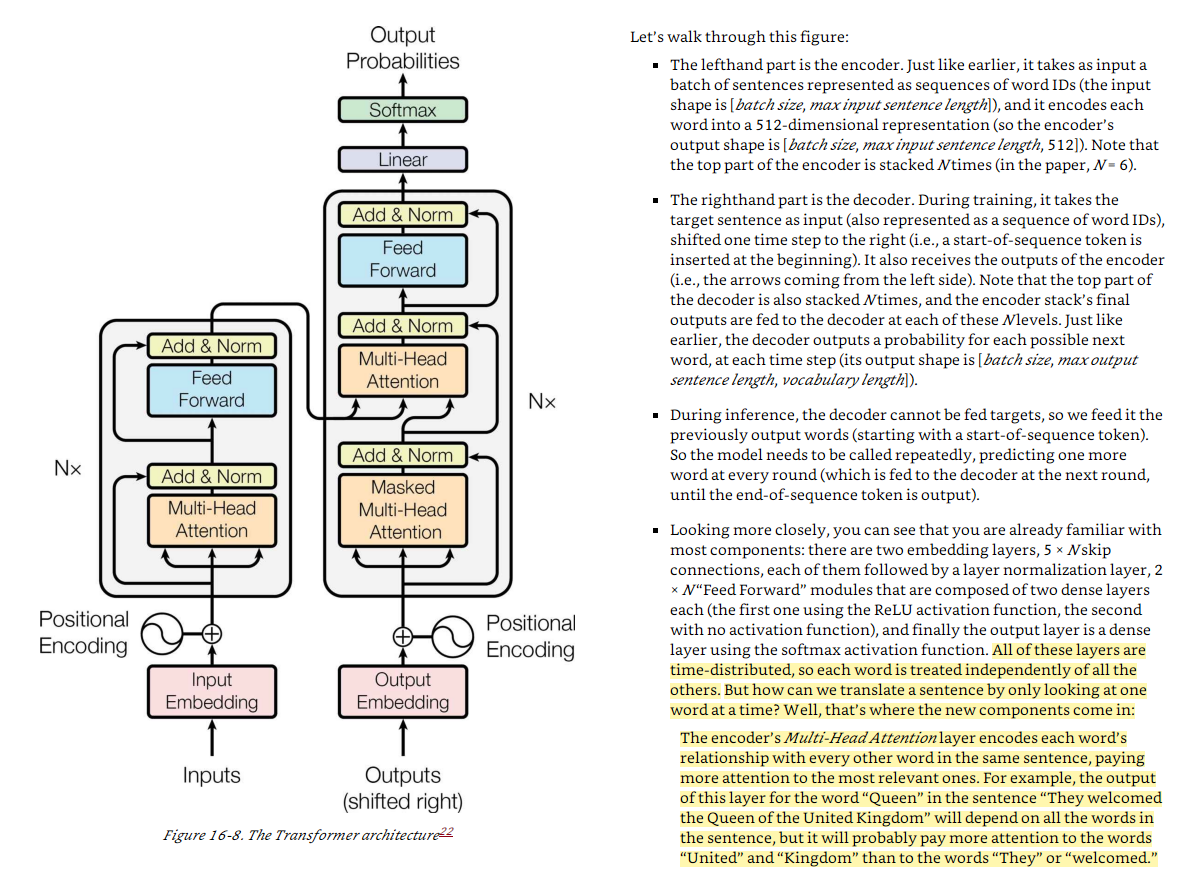

Transformers advanced the state of the art (performed better on sentence classification and similar tasks) by using less training time, scoring better, and being more parallizable. So, why are transformers so succesful? It's because of the multi-head attention layers. The multi-head attention layers work by doing *self-attention*: For each word in the sentence being currently analyzed, the multi-head layer looks at every other word in the sentence in relation to the current word and links the words by virtue of their relavance. For example, if we have the sentence, "The Queen of England is going to the mall," and we are looking at "Queen" in relation to all the other words, then "England" and "mall" will likely be assigned higher salience/weight than "the" and "is." Then, the masked multi-head attention module is the same as the multi-head attention module but can only look at the words prior to the current word.

### Positional Encoding
is a feature of the transformer. Since every layer in the Transformer is timedistributed (which transforms input from shape (batch_size, time_step, etc.) to (batch_size * time_step, etc.), and so ignores the time dimension--and so cannot see the positions of words in the sentece), the layers need some way to obtain information about where the words are located in each sentence. To do this, we have the positional encoding layer. (The multi-head attention layers only learn the relationships of semantic properties of words, not their positions.) So, the positional encoding layer does this by putting the position of the n'th word in the n'th embedding, and so a feature of the embedding is thus the position of the word words.

### Multi-Head Attention
So, say we have a sentence "Dogs fly." So, it's believed that the encoder performs the task of generating keys which represent the particular instances in the sentence. For example, the encoder could discover the concept of verb and noun, and so generate something that approximates a hash table: {Noun: 'Dogs', Verb: 'fly'}. Then, the job of the decoder is to interface with the output from the encoder such that the decoder can access the right key to get the right value. So, if the transformer had already succesfully translated "Dogs" and succesfully predicted that the next item to generate is a verb, then the transformer needs to generate the appropriate key--but the decoder is actually in the business of generating patterns that are just good enough. So, the encoder generates categories and the decoder determines a means of accessing the right categories when given the appropriate inputs. Hence, Geron says that transformers can be thought of as differentiable dictionary lookups. However, Christian Szegedy believes that the transformer is discovering programs that are more general than generating categories and means of accessing the right categories. But anyways, the encoder can be thought of as generating categories and the decoder is in the business of navigating the category structure produced by the encoder.

But how is the attention actually computed? The main idea is to use the dot product on outputs from the encoder and decoder, which we do in a matrix QK^t. We have a simple formula:

                                    Attention(Q, K, V) = softmax(QK^t / sqrt(d_keys))V .
Where Q is the matrix of queries from the decoder, K is the matrix of keys from the encoder, V is a matrix with one row per entry that scales the outputs from the softmax, d_keys is the number of dimensions for the keys. We scale the input to the softmax function by sqrt(d_keys) so that the gradient does not saturate.

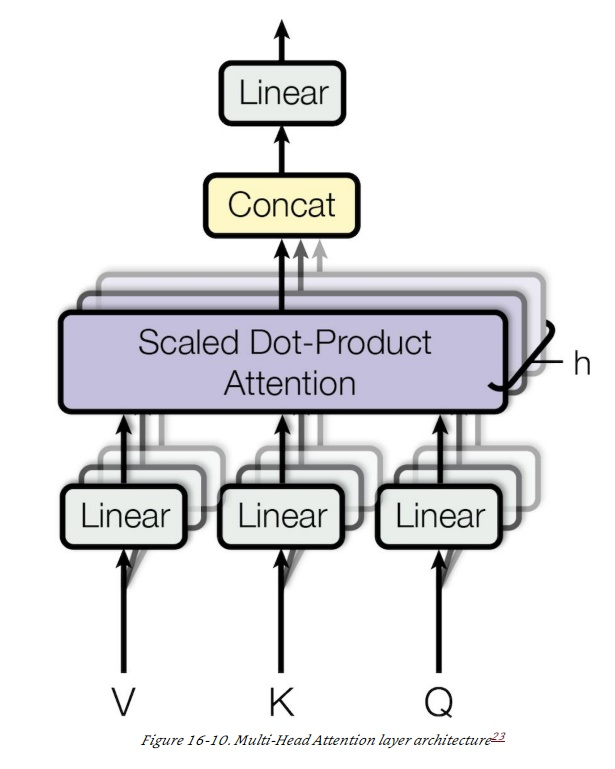

However, what has been described so far is just **Scaled Dot-Product Attention (SDPA)**. What makes **Multi-Head Attention** unique is that it's a layer that performs the SDPA on (Q, K, V) many times in parallel. So, we have an input stream carrying (Q, K, V) and then that input stream branches, carrying the same input down each channel, into different linear transformations that somewhat differentiate each channel and then plug each into a respective SDPA layer, each of which learn to extract and highlight different properties/associations that each word represents by virtue of their respective linear transformation layer (a dense layer without activation function). For example, the word "Dog" has many connotations--one of the SDPA layers may focus on learning about how dogs are a brand of animal, another may focus on how dogs are hairy, another on the fact that Dog is a noun, another on how dogs tend to associate with humans, etc. So, the benefit of multi-head attention is simply that it allows for multiple meanings to be extracted from each word, and so attempts to create a sort of semantic network.